In [1]:
import cv2
import numpy as np

def read_video(video_path):
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        frames.append(frame_rgb)
    
    cap.release()
    
    video = np.stack(frames, axis=0)
    return video

In [2]:
from model.GLUS import GLUSForCausalLM
import torch
from transformers import AutoTokenizer, BitsAndBytesConfig, CLIPImageProcessor
from sam2.utils.transforms import SAM2Transforms

# func for loading model

def load_model(glus_version):

    tokenizer = AutoTokenizer.from_pretrained(
        glus_version,
        cache_dir=None,
        model_max_length=512,
        padding_side="right",
        use_fast=False,
    )
    tokenizer.pad_token = tokenizer.unk_token
    seg_token_idx = tokenizer("[SEG]", add_special_tokens=False).input_ids[0]
    
    torch_dtype = torch.bfloat16
    
    kwargs = {"torch_dtype": torch_dtype}
    kwargs.update(
        {
            "not_use_mem_bank": False,
        }
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')

    model = GLUSForCausalLM.from_pretrained(
        glus_version, low_cpu_mem_usage=False, vision_tower="openai/clip-vit-large-patch14", seg_token_idx=seg_token_idx,
        sam_config="sam2_hiera_l.yaml", image_features_num=63, **kwargs
    )
    
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.bos_token_id = tokenizer.bos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    model.get_model().initialize_vision_modules(model.get_model().config)
    
    vision_tower = model.get_model().get_vision_tower()
    vision_tower.to(dtype=torch_dtype)
    model.to(torch_dtype).cuda()
    model.eval()
    
    clip_image_processor = CLIPImageProcessor.from_pretrained(model.config.vision_tower)
    transform = SAM2Transforms(1024, mask_threshold=0.0)
    
    return model, clip_image_processor, transform, tokenizer, torch_dtype

In [3]:
from model.llava import conversation as conversation_lib
from utils.utils import (DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN,
                         DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX, CONTEXT_INFO_LIST, SHORT_QUESTION_LIST)
from model.llava.mm_utils import tokenizer_image_token

def inference_video(model, clip_image_processor, transform, tokenizer, images, target_obj, dtype):
    model.clear_mem_bank()
    conv = conversation_lib.conv_templates["llava_v1"].copy()
    conv.messages = []
    
    vid_len = len(images)
    context_frame_num = 4
    question_frame_num = 4
    i = 0
    
    masks_list = []
    full_images, full_images_clip = [], []
    
    for image_np in images:
        
        original_size_list = [image_np.shape[:2]]

        image_clip = (
            clip_image_processor.preprocess(image_np, return_tensors="pt")[
                "pixel_values"
            ][0]
        )
        image_clip = image_clip.to(dtype)

        image = transform(image_np).contiguous()
        resize_list = [image.shape[:2]]
        image = image.to(dtype)
        
        full_images.append(image)
        full_images_clip.append(image_clip)
        
    context_id = np.linspace(0, len(images)-1, num=context_frame_num, dtype=int)
    context_frames = [full_images[id] for id in context_id]
    context_frames_clip = [full_images_clip[id] for id in context_id]
    
    while i < vid_len:
        i += 1
        
        images = context_frames + full_images[max(0, i-question_frame_num):i]
        images_clip = context_frames_clip + full_images_clip[max(0,i-question_frame_num):i]
        
        images = torch.stack(images, dim=0).unsqueeze(0).cuda()
        images_clip = torch.stack(images_clip, dim=0).unsqueeze(0).cuda()
        
        answer_prompt = "Sure, the segmentation result is "
        
        if i == 1:
            q_prompt = CONTEXT_INFO_LIST[0].format(class_name=target_obj.lower())
            q_prompt += SHORT_QUESTION_LIST[0].format(class_name=target_obj.lower())
        else:
            q_prompt = SHORT_QUESTION_LIST[0].format(class_name=target_obj.lower())
        replace_token = (
            DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
        )
        q_prompt = q_prompt.replace(DEFAULT_IMAGE_TOKEN, replace_token)
        conv.append_message(conv.roles[0], q_prompt)
        conv.append_message(conv.roles[1], answer_prompt)
            
        if i > question_frame_num:
            conv.messages = conv.messages[2:]
            q_prompt = CONTEXT_INFO_LIST[0].format(class_name=target_obj.lower())
            q_prompt += SHORT_QUESTION_LIST[0].format(class_name=target_obj.lower())
            replace_token = (
                DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
            )
            q_prompt = q_prompt.replace(DEFAULT_IMAGE_TOKEN, replace_token)
            conv.messages[0][-1] = q_prompt
                        
        prompt = "</s>".join(conv.get_prompt().split("</s>")[:-1])
        
        input_ids = tokenizer_image_token(prompt, tokenizer, return_tensors="pt")
        input_ids = input_ids.unsqueeze(0).cu
    
        output_ids, pred_masks, _ = model.evaluate(
            images_clip,
            images,
            input_ids,
            resize_list,
            original_size_list,
            rel_pos_list=list(range(max(0, i - question_frame_num), i)),
            mask_clips_list=None,
            max_new_tokens=1,
            tokenizer=tokenizer,
            context_frame_num=context_frame_num,
            question_frame_num=min(i, question_frame_num),
            mem_stride=3,
            decode_iter=True,
        )
        
        if pred_masks == None:
            print(f"Failed to generate image {i - 1} in current video. Auto-fill an [SEG] and while mask here.")
            conv.messages[-1][-1] += '[SEG] .'
            mask = torch.zeros(original_size_list[-1])
            masks_list.append(mask.unsqueeze(0))
            continue
        masks_list.append((pred_masks[-1][0] > 0).int())
        
        output_ids = output_ids[0][output_ids[0] != IMAGE_TOKEN_INDEX]
        text_output = tokenizer.decode(output_ids, skip_special_tokens=False).strip()
        text_output = text_output.replace("\n", "").replace("  ", " ")
        
        conv.messages[-1][-1] = text_output.split("ASSISTANT: ")[-1].split("</s>")[0] + '.'
        
    return masks_list
        

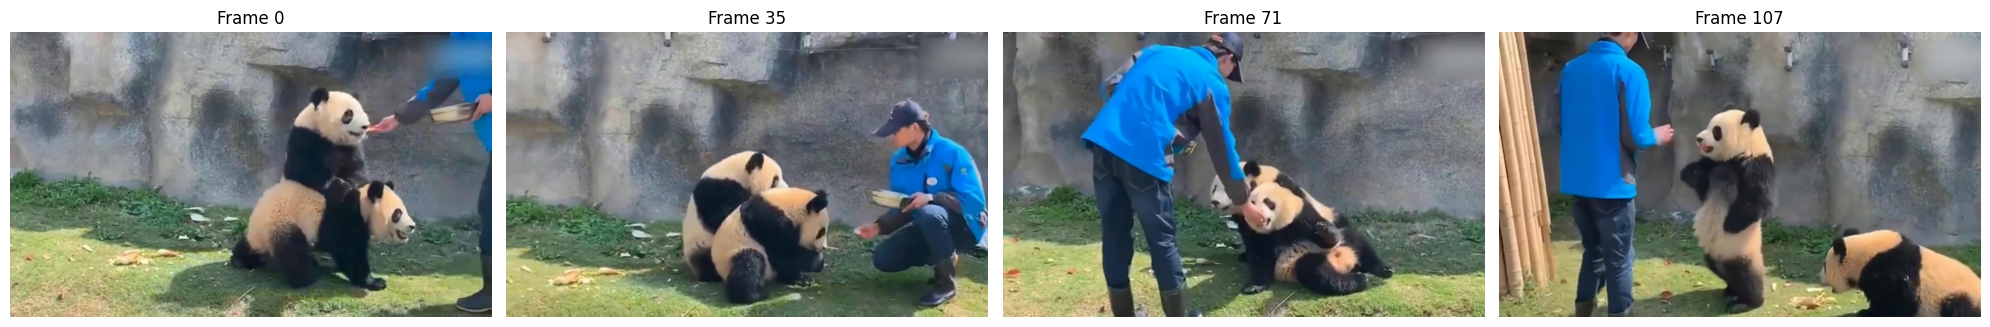

In [8]:
import matplotlib.pyplot as plt

# read video

frames = read_video(video_path="./demo/video.mp4")

# show 4 frames

total_frames = len(frames)
indices = np.linspace(0, total_frames-1, num=4, dtype=int)
selected_frames = frames[indices]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (frame, ax) in enumerate(zip(selected_frames, axes)):
    ax.imshow(frame)
    ax.set_title(f"Frame {indices[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# get model

model, clip_image_processor, transform, tokenizer, torch_dtype = load_model(
    glus_version = 'Swindl/GLUS-S'
)

print(model)

# Ignore the error message when loading the model since we have an inner checkpoint loading for SAM-2. This is caused due to the conflict of the parameter 'gamma' when training with deepspeed.

/u/llin5/miniconda3/envs/lisasam2_no_pe/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at Swindl/GLUS-S were not used when initializing GLUSForCausalLM: ['model.visual_model.memory_encoder.fuser.layers.1.weight', 'model.visual_model.memory_encoder.fuser.layers.0.weight']
- This IS expected if you are initializing GLUSForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GLUSForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GLUSForCausalLM were not initialized from the model checkpoint at Swindl/GLUS-S and are newly initialized: ['model.visual_model.memory_encoder.fuser.layers.0.gamma', 'model.visual_model.memory_encoder.fuser.layers.1.gamma']
You should probably TRAIN this model on a down-stream task to be able to 

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

GLUSForCausalLM(
  (model): GlusModel(
    (embed_tokens): Embedding(32004, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm

In [9]:
# Referring
target_obj = 'The panda that has stayed in place with little movement'

# Run inference
masks = inference_video(
    model=model, 
    clip_image_processor=clip_image_processor, 
    transform=transform, 
    tokenizer=tokenizer, 
    images=frames, 
    target_obj=target_obj, 
    dtype=torch_dtype
)

masks = np.stack([mask.cpu() for mask in masks], axis=0)[:, 0]
print('check shape:', masks.shape, frames.shape)

check shape: (108, 864, 1460) (108, 864, 1460, 3)


Masked video is saved to './demo/masked_video.mp4'.


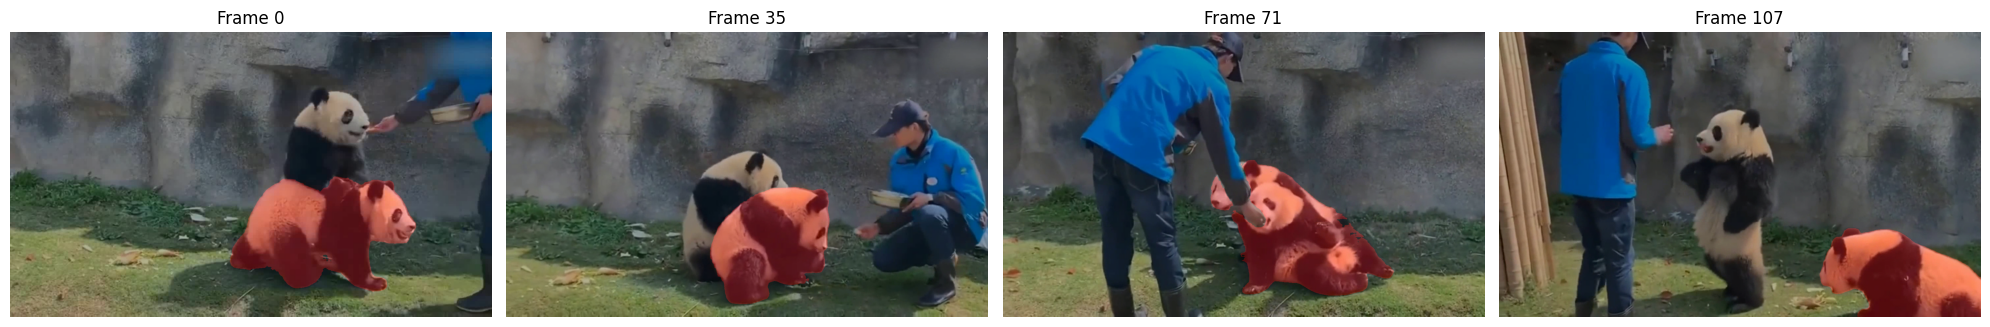

In [11]:
def apply_segmentation(frame, segmentation_frame):
    segmentation_frame_colored = np.zeros_like(frame)
    segmentation_frame_colored[:, :, 0] = segmentation_frame*255  # Apply red color to the segmentation
    return cv2.addWeighted(frame, 0.7, segmentation_frame_colored, 0.3, 0)

masked_frames = []
height, width, _ = frames[0].shape
save_path = './demo/masked_video.mp4'
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

for frame, mask in zip(frames, masks):
    masked_frame = apply_segmentation(frame, mask)
    masked_frames.append(masked_frame)
    out.write(masked_frame[:, :, ::-1])

out.release()
print(f"Masked video is saved to '{save_path}'.")

# show 4 masked frames

total_frames = len(masked_frames)
indices = np.linspace(0, total_frames-1, num=4, dtype=int)
selected_frames = [masked_frames[indice] for indice in indices]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (frame, ax) in enumerate(zip(selected_frames, axes)):
    ax.imshow(frame)
    ax.set_title(f"Frame {indices[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()